In [4]:
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree as KDTree
import statsmodels.api as sm
import numpy as np
import pandas as pd
import gdal
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def inRaster(file_raster):
    raster = gdal.Open(file_raster, gdal.GA_ReadOnly)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    extent = raster.GetGeoTransform()
    return raster, array, extent

In [6]:
def saveRaster(path, array, raster, datatype=6, formatraster="GTiff"):
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = raster.RasterXSize
    rows = raster.RasterYSize
    bands = raster.RasterCount
    datatype = datatype#6#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = raster.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = raster.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster
    outBand = outDataset.GetRasterBand(1)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [7]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [8]:
def IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units):
    """
    INPUT:
    data           = dataframe that contains the hourly station data
    columns        = parater to use for interpolation ('T')
    conversion     = conversion to apply on the parameter (0.1)
    shift          = shift to apply, e.g degrees to K (shift = 273.15)
    stat           = resample hour values to daily values, can be 'mean', 'max', 'min' or 'sum'
    baseDir        = directory to use as base to store IDW output 
                     (r'D:\Projects\Pr\3492.10\KNMI\InterpolatedData\Tmax//')
    templateRaster = file to raster that will be used as template for interpolation
                     (r'D:\Projects\Pr\3492.10\DIDSLF_NL//RD_prj_base.tif')
    units          = units of parameter for colorbar label

    OUTPUT:
    none
    """
    # select colums with parameter and the X/Y coordinates in RD projection
    data = data[[columns,'X_RD','Y_RD']]

    # next lines are important!@
    # resample from hour values to daily values taking the AVERAGE value of the day
    level_values = data.index.get_level_values
    if stat == 'max':
        data_day = (data.groupby([level_values(i) for i in [0]] + [pd.Grouper(freq='1D', level=-1)]).max())
    if stat == 'min':
        data_day = (data.groupby([level_values(i) for i in [0]] + [pd.Grouper(freq='1D', level=-1)]).min())
    if stat == 'mean':
        data_day = (data.groupby([level_values(i) for i in [0]] + [pd.Grouper(freq='1D', level=-1)]).mean())
    if stat == 'sum':
        data_day = (data.groupby([level_values(i) for i in [0]] + [pd.Grouper(freq='1D', level=-1)]).sum())        

    # apply conversion for temperature as the notation is in 0.1 degrees Celsius (at +1.5 mNAP)
    data_day[columns] *= conversion
    data_day[columns] += shift
    data_day = data_day[pd.notnull(data_day[columns])]

    # display head(5)
    data_day.head()

    # select first day of which data is available
    date_selected = data_day.index.get_level_values('Datum').unique()[0]

    # select all datA from stations that has data for this selected datE
    day_df = data_day.iloc[data_day.index.get_level_values('Datum') == date_selected]

    tree = KDTree(list(zip(day_df['X_RD'],day_df['Y_RD'])), leafsize=11)

    day_df.head()

    # table data is finished and right shape, next load a template raster to use as base for interpolation

    # read grid as template for IDW application
    raster, array, extent = inRaster(templateRaster)

#     # plot as test
#     plt.imshow(array)
#     plt.show()

    # create array with all coordinates in array using the extent
    x_steps = np.arange(array.shape[1]) * extent[1]
    y_steps = np.arange(array.shape[0]) * extent[-1]        
    x_coords = extent[0] + x_steps + extent[1]/2
    y_coords = extent[3] + y_steps + extent[-1]/2        
    xy = cartesian([x_coords, y_coords])
    #print ('xy coordinates shape:', xy.shape, '\nlooks like:\n',xy[0:5])
    array = array.T

    # Do it in batch mode!

    # select first day of which data is available
    for date_selected in data_day.index.get_level_values('Datum').unique():

        # select all datA from stations that has data for this selected datE
        day_df = data_day.iloc[data_day.index.get_level_values('Datum') == date_selected]

        tree = KDTree(list(zip(day_df['X_RD'],day_df['Y_RD'])), leafsize=11)

        # IDW KDTREE
        dist, idx = tree.query(xy, k=8, eps=0, p=1)
        #columns = 'T'
        tmp = day_df[[columns]].values.T[:, idx, None]
        tmp = np.squeeze(tmp)
        weights = (1/dist)**2
        q = np.sum(weights, axis=1)
        q = q[:,None]
        weightsq =  weights / q
        wz = np.einsum("ij,ij->i", weightsq, tmp)

        # reshape to shape array
        outArray = wz.reshape([array.shape[0],array.shape[1]]).T   
    #     im = plt.imshow(outArray)
    #     plt.colorbar()
    #     plt.show()

        # save the file
        file_out = columns+stat+'_'+date_selected.strftime('%Y%m%d')+'_'+str(date_selected.dayofyear).zfill(3)+'.tif'
        path_out = os.path.join(baseDir, file_out)
        #print ('path to save: ',path_out)
        saveRaster(path_out, outArray, raster)
    
    im = plt.imshow(outArray)
    plt.title(columns+stat)    
    cb = plt.colorbar()
    cb.set_label(units)
    plt.show()        
    return print('Function returned no errors')

In [9]:
# read locations file and set station code as object type and change columns names
locations_file = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\KNMI//locations.csv'
locations = pd.read_csv(locations_file)
locations['SCODE'] = locations['SCODE'].astype(str).str.zfill(3)
locations.rename(columns = {'X':'X_RD'}, inplace = True)
locations.rename(columns = {'Y':'Y_RD'}, inplace = True)
locations.head()

,HCODE,SCODE,LON,LAT,X_RD,Y_RD,Z,SNAAM
0,1,210,4.42,52.16,88757.74,464535.30,-43.51,VALKENBURG
1,2,225,4.58,52.46,99802.05,497559.47,-38.40,IJMUIDEN
2,3,235,4.79,52.92,114500.72,548715.77,-41.46,DE_KOOY
3,4,240,4.77,52.30,113173.42,479401.88,-47.49,SCHIPHOL
4,5,242,4.94,53.26,125286.46,585474.16,-40.43,VLIELAND


In [11]:
# read csv data, and skip the first 81 rows and for each column skip the initial spaces
data_file = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\KNMI//KNMI_20170305_hourly_2015.txt'
data = pd.read_csv(data_file, skiprows=81, sep=',', skipinitialspace=True)

# for the hours subtract 1 as pandas daterange for hour goes from 0 - 23 
# but data reported from 1 - 24
data['HH'] = data['HH'] - 1
data['HH'] = data['HH'].astype(str).str.zfill(2)

# convert location id from int64 to object 
data['STN'] = data['STN'].astype(str).str.zfill(3)

# combine column year-month-day with column hour and convert to datetime
data['Datum'] = data['YYYYMMDD'].map(str) + data['HH']
data['Datum'] = pd.to_datetime(data['Datum'], format='%Y%m%d%H')

# join the data and location table on station name
data = pd.merge(data, locations, how='inner', left_on='STN', right_on='SCODE')

# set multiindex based on location and datum column
data.set_index(['STN','Datum'], inplace=True) # 
# display head(5)
data.head()

YYYYMMDD  HH     DD     FH     FF     FX     T  T10  \
STN Datum                                                                      
210 2015-03-01 00:00:00  20150301  00  180.0  110.0  110.0  170.0  67.0  NaN   
    2015-03-01 01:00:00  20150301  01  190.0  110.0  110.0  160.0  69.0  NaN   
    2015-03-01 02:00:00  20150301  02  200.0  110.0  100.0  170.0  69.0  NaN   
    2015-03-01 03:00:00  20150301  03  210.0   90.0   90.0  130.0  83.0  NaN   
    2015-03-01 04:00:00  20150301  04  230.0  110.0  110.0  170.0  88.0  NaN   

                           TD   SQ     ...        O    Y  HCODE  SCODE   LON  \
STN Datum                              ...                                     
210 2015-03-01 00:00:00  53.0  0.0     ...      0.0  0.0      1    210  4.42   
    2015-03-01 01:00:00  57.0  0.0     ...      0.0  0.0      1    210  4.42   
    2015-03-01 02:00:00  63.0  0.0     ...      0.0  0.0      1    210  4.42   
    2015-03-01 03:00:00  75.0  0.0     ...      0.0  0.0      1    210  4.42   
    2015-03-01 04:00:00  72.0  0.0     ...      0.0  0.0      1    210  4.42   

                           LAT      X_RD      Y_RD      Z       SNAAM  
STN Datum                                                              
210 2015-03-01 00:00:00  52.16  88757.74  464535.3 -43.51  VALKENBURG  
    2015-03-01 01:00:00  52.16  88757.74  464535.3 -43.51  VALKENBURG  
    2015-03-01 02:00:00  52.16  88757.74  464535.3 -43.51  VALKENBURG  
    2015-03-01 03:00:00  52.16  88757.74  464535.3 -43.51  VALKENBURG  
    2015-03-01 04:00:00  52.16  88757.74  464535.3 -43.51  VALKENBURG  

[5 rows x 32 columns]

In [40]:
# template raster file
templateRaster = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\BASE_RD//RD_prj_base.tif'
#templateRaster = r'D:\Projects\Pr\3492.10\ALBEDO\asc//base_v2_zeros.tif'
baseDir = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\KNMI\tif_IDW'

In [10]:
# APPLY THE INTERPOLATION FOR EACH PARAMETER

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


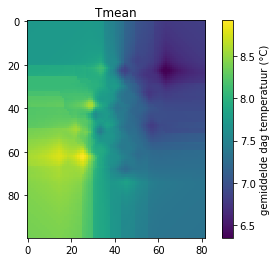

Function returned no errors


In [14]:
# T        = Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 0
stat           = 'mean'
units          = 'gemiddelde dag temperatuur (°C)'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


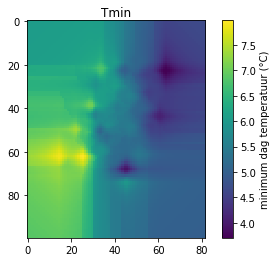

Function returned no errors


In [18]:
# Tmin        = MIN Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 0
stat           = 'min'
units          = 'minimum dag temperatuur (°C)'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


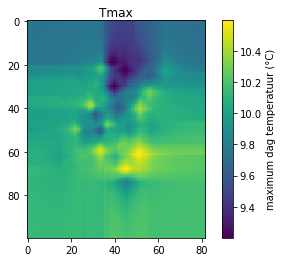

Function returned no errors


In [21]:
# Tmax        = MAX Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 0
stat           = 'max'
units          = 'maximum dag temperatuur (°C)'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


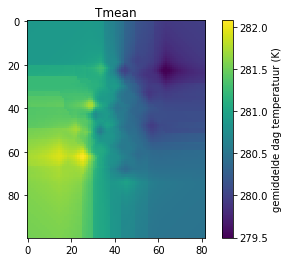

Function returned no errors


In [24]:
# T        = Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 273.15
stat           = 'mean'
units          = 'gemiddelde dag temperatuur (K)'

# save in this directory
baseDir        = os.path.join(baseDir,'K'+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


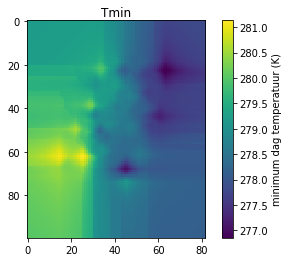

Function returned no errors


In [26]:
# T        = Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 273.15
stat           = 'min'
units          = 'minimum dag temperatuur (K)'

# save in this directory
baseDir        = os.path.join(baseDir,'K'+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


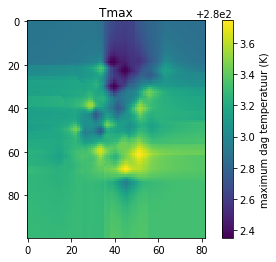

Function returned no errors


In [33]:
# T        = Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'T'
conversion     = 0.1
shift          = 273.15
stat           = 'max'
units          = 'maximum dag temperatuur (K)'

# save in this directory
baseDir        = os.path.join(baseDir,'K'+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


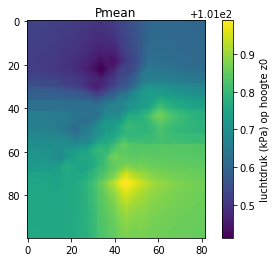

Function returned no errors


In [35]:
# P        = Luchtdruk (in 0.1 hPa) herleid naar zeeniveau, tijdens de waarneming; 
columns        = 'P'
conversion     = 0.01  # x 0.1 = naar hPa x 0.01 is naar kPa
shift          = 0
stat           = 'mean'
units          = 'luchtdruk (kPa) op hoogte z0'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


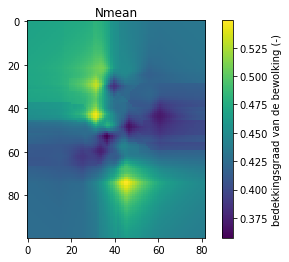

Function returned no errors


In [37]:
# N        = Bewolking (bedekkingsgraad van de bovenlucht in achtsten), tijdens de waarneming (9=bovenlucht onzichtbaar); 
columns        = 'N'
conversion     = 1/9.
shift          = 0
stat           = 'mean'
units          = 'bedekkingsgraad van de bewolking (-)'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


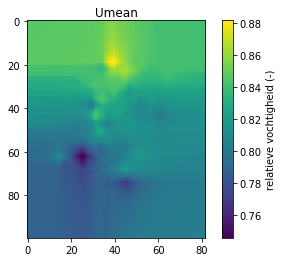

Function returned no errors


In [39]:
# U        = Relatieve vochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming; 
columns        = 'U'
conversion     = 0.01
shift          = 0
stat           = 'mean'
units          = 'relatieve vochtigheid (-)'

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


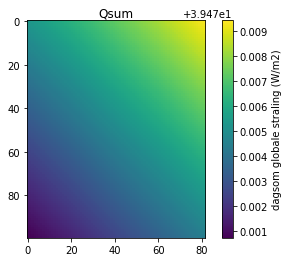

Function returned no errors


In [41]:
# Q        = Globale straling (in J/cm2) per uurvak; 
columns        = 'Q'
conversion     = 1/8.64
shift          = 0
stat           = 'sum'
units          = 'dagsom globale straling (W/m2)'
# returns Q Globale straling (in W/m2) per dagvak; 

# save in this directory
baseDir        = os.path.join(baseDir,columns+stat)

# do the work
IDW_KNMIstations(data,columns,conversion,shift,stat,baseDir,templateRaster,units)

In [ ]:
# file_Raster = r'D:\Projects\Pr\3492.10\ALBEDO\high_resolution//base_v2.tif'
# file_Raster_out = r'D:\Projects\Pr\3492.10\Water\diisolve//water_dissolved_int.tif'
# raster, array, extent = inRaster(file_Raster)

In [ ]:
# array_zero = np.full_like(array,0).astype(int)
# saveRaster(file_Raster_out,array_zero, raster, datatype=1)

In [ ]:
# array_zero.astype(int)